In [1]:
from dynamita.sumo import *

import numpy as np
import time
import copy as cp
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
sumo = Sumo(sumoPath="C:/Users/Sara/AppData/Local/Dynamita/Sumo19",
           licenseFile=r"C:/Users/Sara/Desktop/sewerWRRF/networklicense.sumolic")

License OK...


In [3]:
def datacomm_callback(sumo):
    t_set.append(sumo.core.csumo_var_get_time_double(sumo.handle))
    
    q_infl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, q_infl_pos))
    snhx_infl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, snhx_infl_pos))
    
    q_effl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, q_effl_pos))
    snhx_effl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, snhx_effl_pos))
    
    return 0

sumo.unload_model()
sumo.load_model('A2O plant.sumo')
    
sumo.core.csumo_command_send(sumo.handle, b'execute script_Initialize.scs;')
    
sumo.register_datacomm_callback(datacomm_callback)

def message_callback(sumo):
    for message in sumo.messages:
        print(message)
    sumo.messages = []
    return 0

sumo.register_message_callback(message_callback)

sumo.set_stopTime(2*24*60*60*1000)
sumo.set_dataComm(50*60*1000)

No model is loaded
530021 Set: Sumo__StopTime to 0
530021 Set: Sumo__DataComm to 3600000
530021 Set: Sumo__PlantName to C:\Users\DYNAMI~1\AppData\Local\Dynamita\Sumo18\TMP~1\xjzoiwqs.cba\SUMOPR~1.XML
530049 Core loop started.
530036 Script file script_Initialize.scs loaded.
530020 Set mode: dynamic
530021 Set: Sumo__Plant__CSTR__param__L_V to 1000
530021 Set: Sumo__Plant__CSTR__param__Qair_N to 0
530021 Set: Sumo__Plant__CSTR2__param__L_V to 1500
530021 Set: Sumo__Plant__CSTR2__param__Qair_N to 0
530021 Set: Sumo__Plant__CSTR3__param__L_V to 4500
530021 Set: Sumo__Plant__Sideflowdivider__param__Qpumped_target to 72000
530021 Set: Sumo__StopTime to 172800000
530021 Set: Sumo__DataComm to 3000000


In [4]:
# Store positions for variables of interest
q_infl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Influent__Q')
snhx_infl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Influent__SNHx')

q_effl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Effluent__Q')
snhx_effl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Effluent__SNHx')

In [5]:
infl = {}
effl = {}

In [7]:
for q in [20000, 24000, 28000]:
    command = 'set Sumo__Plant__Influent__param__Q ' + str(q) + ';'

    sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
    
    t_set = []
    q_infl_set = []
    snhx_infl_set = []
    
    q_effl_set = []
    snhx_effl_set = []
    
    sumo.run_model()
    
    while not sumo.simulation_finished:
        time.sleep(0.01)
    
    infl[q] = np.array([q_infl_set, snhx_infl_set])
    
    effl[q] = np.array([q_effl_set, snhx_effl_set])

530021 Set: Sumo__Plant__Influent__param__Q to 20000
530002 Simulation started.
530004 Simulation ended.
530021 Set: Sumo__Plant__Influent__param__Q to 24000
530002 Simulation started.
530004 Simulation ended.
530021 Set: Sumo__Plant__Influent__param__Q to 28000
530002 Simulation started.
530004 Simulation ended.


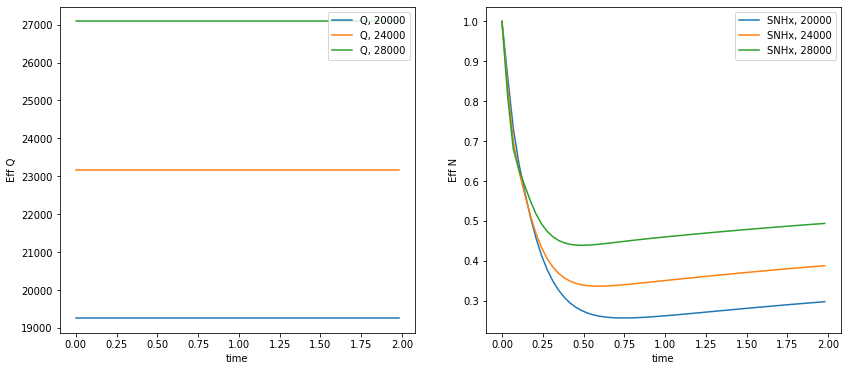

In [8]:
fig, axes = plt.subplots(1,2, figsize=(14,6))

axes[0].set_xlabel('time')
axes[0].set_ylabel('Eff Q')

axes[1].set_xlabel('time')
axes[1].set_ylabel('Eff N')

for q, array in effl.items():
    # Flow
    axes[0].plot(t_set, array[0], label='Q, '+str(q))
    # Nitrogen: SNHx
    axes[1].plot(t_set, array[1], label='SNHx, '+str(q))

axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right')